<a href="https://colab.research.google.com/github/m3sibti/DL_projects/blob/master/Keras_cyclegan_mw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cycle-GAN

Image-to-Image Unpaired Translation

## Imports

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage.interpolation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image

## Some Parameters
- lr = 0.0002
- bs = 32
- epochs = 100000
- img_dim = 784

## Prepare the dataset

In [6]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

print('Training Samples ', x_train.shape)
print('Test Samples',x_test.shape)
x_data = np.vstack((x_train, x_test))
print('Combined Samples', x_data.shape)

Training Samples  (60000, 28, 28)
Test Samples (10000, 28, 28)
Combined Samples (70000, 28, 28)


Find the mid point and rotate the other half to create a second domain Y against first half X

In [0]:
mid_point = int(x_data.shape[0]/2)

In [0]:
x_real = x_data[:mid_point]
x_real = x_real.reshape(-1, 28*28)

In [0]:
x_rotated = x_data[mid_point:].reshape(-1, 28, 28)
x_rotated = scipy.ndimage.interpolation.rotate(x_rotated, 90, axes=(1, 2))
x_rotated = x_rotated.reshape(-1, 28*28)

In [14]:
x_real.shape, x_rotated.shape

((35000, 784), (35000, 784))

Visualize the Images

<Figure size 720x720 with 0 Axes>

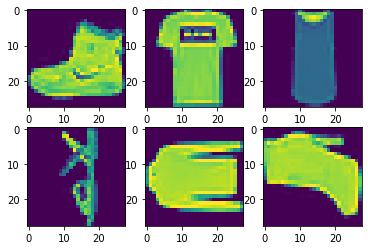

In [38]:
plt.figure(figsize=(10, 10))
fig, axs = plt.subplots(2, 3)
for i in range(3):
  x_img_real = x_real[i].reshape(28, 28)
  x_img_rotated = x_rotated[i].reshape(28, 28)
  axs[0][i].imshow(x_img_real)
  axs[1][i].imshow(x_img_rotated)
  ax.axis('off')

Normalize the dataset and convert into single dataset object

In [0]:
x_real = x_real / 255.
x_rotated = x_rotated / 255.

In [0]:
data = tf.data.Dataset.from_tensor_slices((x_real, x_rotated))
data = data.shuffle(1024).batch(32).prefetch(16)

## Create Models

### Discriminators

In [0]:
Disc_A = models.Sequential([
                            keras.Input(shape=(784,)),
                            layers.Dense(128, activation='relu',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
                            layers.Dense(1, activation='sigmoid',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
])

Disc_B = models.Sequential([
                            keras.Input(shape=(784,)),
                            layers.Dense(128, activation='relu',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
                            layers.Dense(1, activation='sigmoid',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
])

In [49]:
print(Disc_A.summary())
print(Disc_B.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________
None


### Generators

In [0]:
Gen_AB = models.Sequential([
                            keras.Input(shape=(784,)),
                            layers.Dense(128, activation='relu',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
                            layers.Dense(784, activation='sigmoid',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
])

Gen_BA = models.Sequential([
                            keras.Input(shape=(784,)),
                            layers.Dense(128, activation='relu',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
                            layers.Dense(784, activation='sigmoid',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
])

In [50]:
print(Gen_AB.summary())
print(Gen_BA.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_13 (Dense)             (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_15 (Dense)             (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________
None


## Override Training Step

In [0]:
class CycleGAN(models.Model):

  def __init__(self, ):
    pass

  def compile(self,):
    pass

  def train_step(self):
    pass